# LSTM - Continuous Times - raw LFP data (no epochs).
- The model is configured for sequence-to-sequence classification (a prediction for each time step)
- Label each time point
- 5 KFold
- X = all_lfp_uniform.transpose(0, 2, 1) # Shape becomes (16, 38213, 6)
- y = labels_uniform[:, 0, :] # Choose one channel as target
- class_weight = {0: 1., 1: 10.}
- y_pred.shape (8, 100, 1)

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import mne
import pickle

import tensorflow as tf
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import mean_squared_error, accuracy_score


from gait_modulation import MatFileReader, DataProcessor, Visualise, FeatureExtractor
from gait_modulation import LSTMModel #, BaseModel, RegressionModels
from gait_modulation.utils.utils import split_data_stratified, load_config, generate_continuous_labels, create_lagged_data
from multiprocessing import Pool  # Add multiprocessing
from tensorflow.keras.callbacks import Callback,  ModelCheckpoint, TensorBoard, EarlyStopping, ReduceLROnPlateau



# ------------------ Load Configuration ------------------ #
lfp_metadata_config = load_config('gait_modulation/configs/written/lfp_metadata_config.yaml')
data_preprocessing_config = load_config('gait_modulation/configs/data_preprocessing.yaml')

with open('processed/lfp_raw_list.pkl', 'rb') as f:
    lfp_raw_list = pickle.load(f)
    
    
# ------------------ Data Preprocessing ------------------ #
sfreq = lfp_metadata_config['LFP_METADATA']['lfp_sfreq']
mod_start_event_id = data_preprocessing_config['events']['mod_start_event_id']
normal_walking_event_id = data_preprocessing_config['events']['normal_walking_event_id']
epoch_tmin = data_preprocessing_config['segmentation']['epoch_tmin']
epoch_tmax = data_preprocessing_config['segmentation']['epoch_tmax']



# ------------------ Data Preprocessing ------------------ #
random_state = 42

# Generate continuous labels for each trial in the list
labels = generate_continuous_labels(lfp_raw_list, epoch_tmin, epoch_tmax, mod_start_event_id, normal_walking_event_id)

lfp_data_list = [] # store LFP data (not mne raw objects) for each trial
for lfp_raw in lfp_raw_list:
    lfp_data_list.append(lfp_raw.get_data())

# truncate the LFP data to ensure uniform length
all_lfp_uniform = DataProcessor.pad_or_truncate(lfp_data_list, data_preprocessing_config)

# truncate the labels to ensure uniform length
labels_uniform = DataProcessor.pad_or_truncate(labels, data_preprocessing_config)

print(all_lfp_uniform.shape, labels_uniform.shape)



# ------------------ Feature Extraction ------------------ #

# Reshape to (trials * times, channels)
# reshaped_all_lfp_uniform = FeatureExtractor.reshape_lfp_data(
#     all_lfp_uniform, mode="flat_time")

# reshaped_labels_uniform = FeatureExtractor.reshape_lfp_data(
#     labels_uniform, mode="flat_time")

# reshaped_all_lfp_uniform.shape, reshaped_labels_uniform.shape

# # # Reshape to (trials, times * channels)
# # reshaped_flat_channel = FeatureExtractor.reshape_lfp_data(
# #     all_lfp_uniform, mode="flat_channel")
# # reshaped_flat_channel.shape

# indices = np.where(reshaped_labels_uniform[:, 0] == 1)[0]
# # print(indices)
# # reshaped_labels_uniform[indices[2]]


# ------------------ Model Training ------------------ #
# Log available devices and GPU details
def _log_device_details():
    print("Available devices:")
    for device in tf.config.list_logical_devices():
        print(device)

    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        print("Running on GPU")
        print(f"Num GPUs Available: {len(gpus)}")
        for i, gpu in enumerate(gpus):
            print(f"\nGPU {i} Details:")
            gpu_details = tf.config.experimental.get_device_details(gpu)
            for key, value in gpu_details.items():
                print(f"{key}: {value}")
    else:
        print("Running on CPU")

    # Log logical GPUs (useful for multi-GPU setups)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(f"\nLogical GPUs Available: {len(logical_gpus)}")
    for i, lgpu in enumerate(logical_gpus):
        print(f"Logical GPU {i}: {lgpu}")

# Enable device placement logging
def _configure_tf_logs():
    tf.debugging.set_log_device_placement(True)
    tf.get_logger().setLevel('ERROR')  # Options: 'DEBUG', 'INFO', 'WARNING', 'ERROR', 'FATAL'
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppress TensorFlow logs

# Clear TensorFlow session and log build details
def _reset_tf_session():
    tf.keras.backend.clear_session()
    print("Built with CUDA:", tf.test.is_built_with_cuda())
    print("Available GPUs:", tf.config.list_physical_devices('GPU'))

# Combine all configuration and logging calls
def initialize_tf():
    _log_device_details()
    _configure_tf_logs()
    _reset_tf_session()

# Initialize TensorFlow configuration
initialize_tf()


# ------------------ Model Training ------------------ #
# X = reshaped_all_lfp_uniform # (samples * time_points, features)
# y = reshaped_labels_uniform # (samples * time_points, features)

X = all_lfp_uniform.transpose(0, 2, 1)[:, :200, :] # Shape becomes (16, 38213, 6)
y = labels_uniform.transpose(0, 2, 1)[:, :200, :]
# y = labels_uniform[:, 0, :][:, :100]  # Choose one channel as target


path_to_classification_lstm_config = 'gait_modulation/configs/classification_lstm_config.yaml'

results = {}



class PrintBatchProgress(Callback):
    def on_train_batch_end(self, batch, logs=None):
        # Print the batch number and relevant logs (e.g., loss and accuracy)
        # print(f"Batch {batch + 1}: Loss = {logs.get('loss', 0.0):.4f}, Accuracy = {logs.get('accuracy', 0.0):.4f}")
        pass


class CustomProgressLogger(Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        print(f"Epoch {epoch + 1}/{self.params['epochs']}")
        print(f"\n---------------------------- Epoch {epoch+1} ----------------------------\n")
    
    def on_batch_end(self, batch, logs=None):
        # logs = logs or {}
        # loss = logs.get('loss', 0.0)
        # accuracy = logs.get('accuracy', 0.0)
        # print(f"Batch {batch + 1}: Loss = {loss:.4f}, Accuracy = {accuracy:.4f}")
        pass
        
def train_model_on_fold(fold_data):
    fold, (train_index, test_index), X, y = fold_data
    
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index, :, 0], y[test_index, :, 0] # label of the first channel
    
    y_train = np.where(y_train == -1, 0, y_train) #TODO
    y_test = np.where(y_test == -1, 0, y_test) #TODO

    print(f'\nFold {fold} Train: {X_train.shape} Test: {X_test.shape}')
    
    lstm_model = LSTMModel("lstm", path_to_classification_lstm_config)

    # Define the callbacks
    tensorboard_callback = TensorBoard(log_dir='logs/fit', histogram_freq=0)  # Set to 0 to disable histogram logging
    
    checkpoint = ModelCheckpoint(
        filepath='best_model.h5', 
        monitor='val_loss', 
        save_best_only=True
    )
    
    callbacks = [
        PrintBatchProgress(),
        CustomProgressLogger(),
        checkpoint,
        tensorboard_callback,
        EarlyStopping(monitor='loss', patience=2, restore_best_weights=True),
        ReduceLROnPlateau(monitor='loss', factor=0.5, patience=1, min_lr=1e-5)
    ]
    
    # Train the model
    lstm_model.fit(X_train, y_train, callbacks)
    
    # Predict on the test set
    y_pred = lstm_model.predict(X_test)
    
    # Save the model
    model_save_path = os.path.join('saved_models', f'lstm_model_fold_{fold}.h5')
    lstm_model.save(model_save_path)
    print(f'Model for fold {fold} saved to {model_save_path}')
    
    # Calculate the mean squared error
    accuracy = accuracy_score(y_test, y_pred)
    
    # Store the results
    results[fold] = {
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test,
        'y_pred': y_pred,
        'acc': accuracy
    }
    return results


n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

# Prepare data for parallel processing
fold_data = [(fold, (train_idx, test_idx), X, y) for fold, (train_idx, test_idx) in enumerate(kf.split(X), 1)]

if __name__ == '__main__':
    # Use multiprocessing to train the model on each fold in parallel
    print('starting parallel training...')
    with Pool(processes=n_splits) as pool:
        results = pool.map(train_model_on_fold, fold_data)

    folds_results = {}
    for result in results:
        folds_results.update(result)
        
    # for fold in range(n_splits):
        # After training, mse_results will contain the MSE for each fold
        # print(f"Mean Squared Errors for each fold: {results[fold]}")
    
    # Ensure the results directory exists
    results_dir = 'results'
    if not os.path.exists(results_dir):
        os.makedirs(results_dir)
    
    # Save the results to a file
    results_path = os.path.join(results_dir, 'continuousTime_results.pkl')
    with open(results_path, 'wb') as f:
        pickle.dump(folds_results, f)
    
    print(f'Results saved to {results_path}')
    
# tensorboard --logdir=./logs or tensorboard --logdir=logs/fit
# http://localhost:6006/


(16, 6, 38213) (16, 6, 38213)
Available devices:
Metal device set to: Apple M2

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

LogicalDevice(name='/device:CPU:0', device_type='CPU')
LogicalDevice(name='/device:GPU:0', device_type='GPU')
Running on GPU
Num GPUs Available: 1

GPU 0 Details:
device_name: METAL

Logical GPUs Available: 1
Logical GPU 0: LogicalDevice(name='/device:GPU:0', device_type='GPU')
Built with CUDA: False
Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
starting parallel training...


2024-12-09 11:49:47.451970: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-09 11:49:47.452631: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
Process SpawnPoolWorker-1:
Traceback (most recent call last):
  File "/Users/orabe/miniconda3/envs/gait_modulation/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/Users/orabe/miniconda3/envs/gait_modulation/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/orabe/miniconda3/envs/gait_modulation/lib/python3.10/multiprocessing/pool.py", line 114, in worker
    task = get(

KeyboardInterrupt: 

In [ ]:
from gait_modulation import MatFileReader, DataProcessor, Visualise, FeatureExtractor
from gait_modulation import BaseModel, RegressionModels, LSTMModel
import pickle

classification_lstm_config_path = 'gait_modulation/configs/classification_lstm_config.yaml'
model_path = 'saved_models/lstm_model_fold_1.h5'
lstm_model = BaseModel.load(model_path, config_file=classification_lstm_config_path)
lstm_model.model.summary()

Metal device set to: Apple M2

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2024-12-08 03:44:11.171485: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-08 03:44:11.171566: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 200, 64)           18176     
                                                                 
 dropout (Dropout)           (None, 200, 64)           0         
                                                                 
 lstm_1 (LSTM)               (None, 200, 64)           33024     
                                                                 
 dense (Dense)               (None, 200, 32)           2080      
                                                                 
 dropout_1 (Dropout)         (None, 200, 32)           0         
                                                                 
 dense_1 (Dense)             (None, 200, 1)            33        
                                                                 
Total params: 53,313
Trainable params: 53,313
Non-traina

In [ ]:
with open('results/continuousTime_results.pkl', 'rb') as f:
    continuousTime_results = pickle.load(f)

In [ ]:
for fold in continuousTime_results.keys():
    y_test = continuousTime_results[fold]['y_test']
    y_pred = continuousTime_results[fold]['y_pred']
    metrics = lstm_model.evaluate(y_test, y_pred)
    print(f"Fold {fold} - {metrics}")
    print(2 * "---------------------------------------")


Fold 1 - {'accuracy': 1.0, 'precision': 0.0, 'recall': 0.0, 'auc': 0.0}
------------------------------------------------------------------------------
Fold 2 - {'accuracy': 1.0, 'precision': 0.0, 'recall': 0.0, 'auc': 0.0}
------------------------------------------------------------------------------
Fold 3 - {'accuracy': 1.0, 'precision': 0.0, 'recall': 0.0, 'auc': 0.0}
------------------------------------------------------------------------------
Fold 4 - {'accuracy': 1.0, 'precision': 0.0, 'recall': 0.0, 'auc': 0.0}
------------------------------------------------------------------------------
Fold 5 - {'accuracy': 1.0, 'precision': 0.0, 'recall': 0.0, 'auc': 0.0}
------------------------------------------------------------------------------


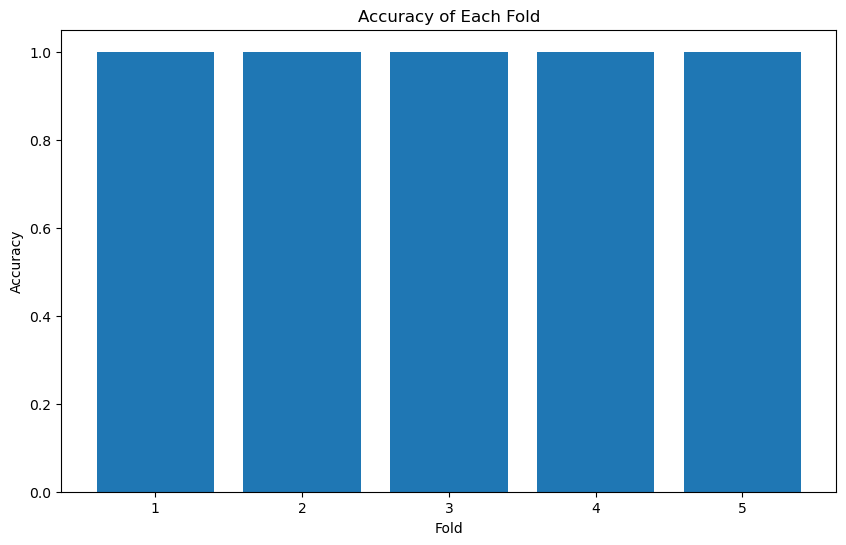

In [ ]:
import matplotlib.pyplot as plt

# Extract accuracy values for each fold
accuracy_values = [continuousTime_results[fold]['acc'] for fold in continuousTime_results.keys()]

# Plot accuracy values for each fold
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(accuracy_values) + 1), accuracy_values)
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.title('Accuracy of Each Fold')
plt.xticks(range(1, len(accuracy_values) + 1))
plt.show()

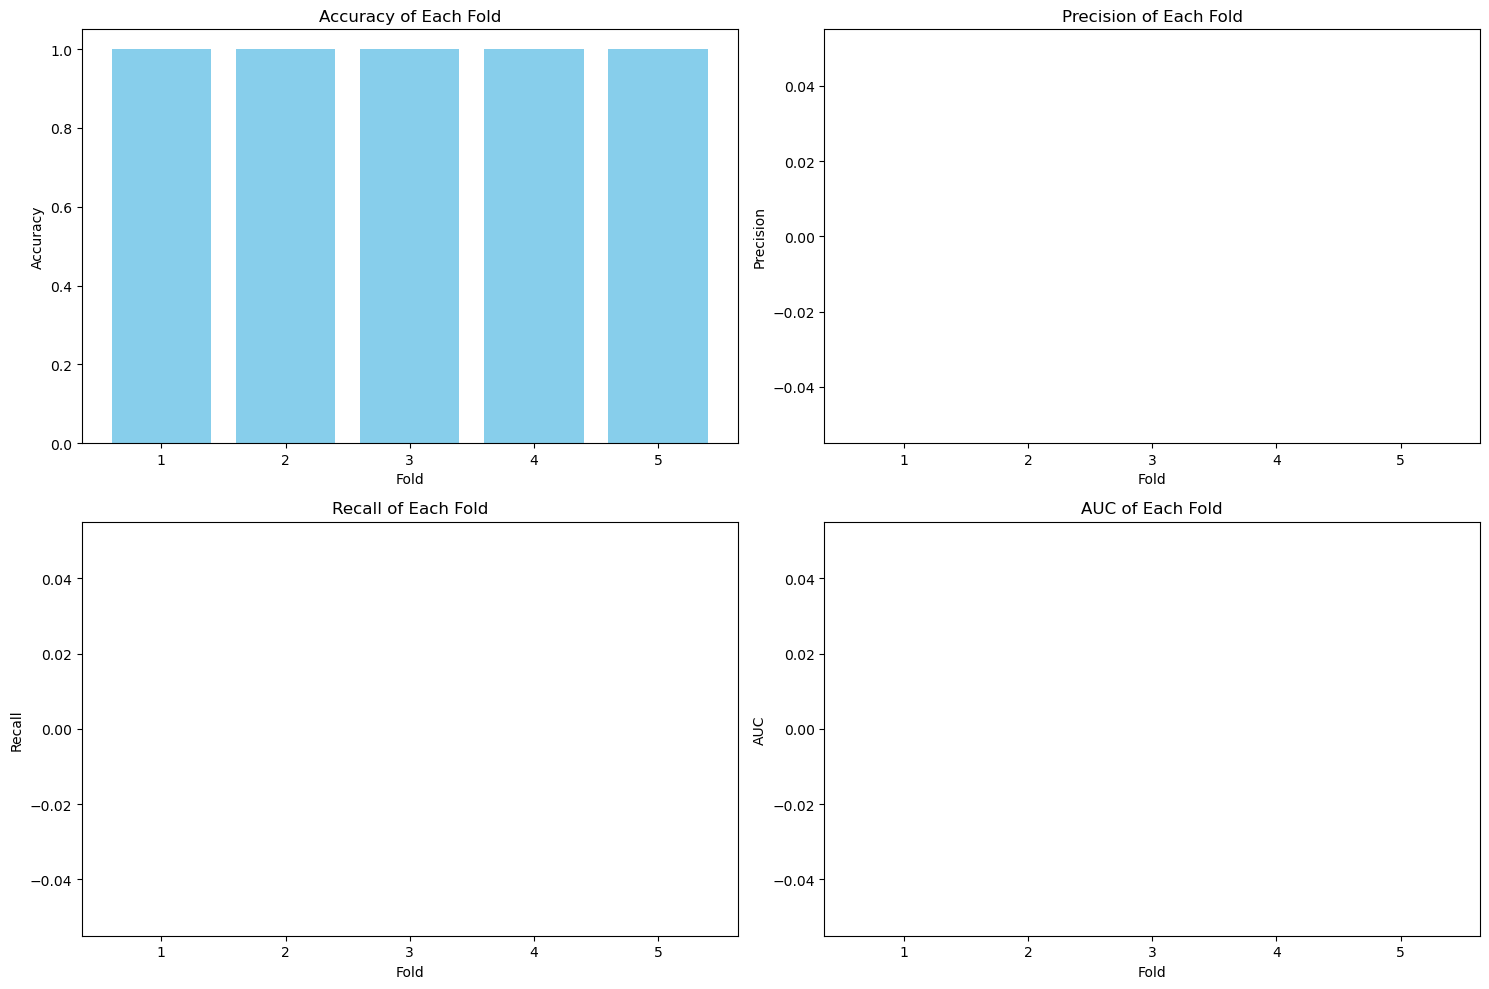

In [ ]:
import matplotlib.pyplot as plt

# Extract metrics for each fold
folds = list(continuousTime_results.keys())
accuracy = [continuousTime_results[fold]['acc'] for fold in folds]
precision = [continuousTime_results[fold].get('precision', 0.0) for fold in folds]
recall = [continuousTime_results[fold].get('recall', 0.0) for fold in folds]
auc = [continuousTime_results[fold].get('auc', 0.0) for fold in folds]

# Plot metrics for each fold
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

# Accuracy
axes[0].bar(folds, accuracy, color='skyblue')
axes[0].set_title('Accuracy of Each Fold')
axes[0].set_xlabel('Fold')
axes[0].set_ylabel('Accuracy')

# Precision
axes[1].bar(folds, precision, color='lightgreen')
axes[1].set_title('Precision of Each Fold')
axes[1].set_xlabel('Fold')
axes[1].set_ylabel('Precision')

# Recall
axes[2].bar(folds, recall, color='salmon')
axes[2].set_title('Recall of Each Fold')
axes[2].set_xlabel('Fold')
axes[2].set_ylabel('Recall')

# AUC
axes[3].bar(folds, auc, color='orange')
axes[3].set_title('AUC of Each Fold')
axes[3].set_xlabel('Fold')
axes[3].set_ylabel('AUC')

plt.tight_layout()
plt.show()

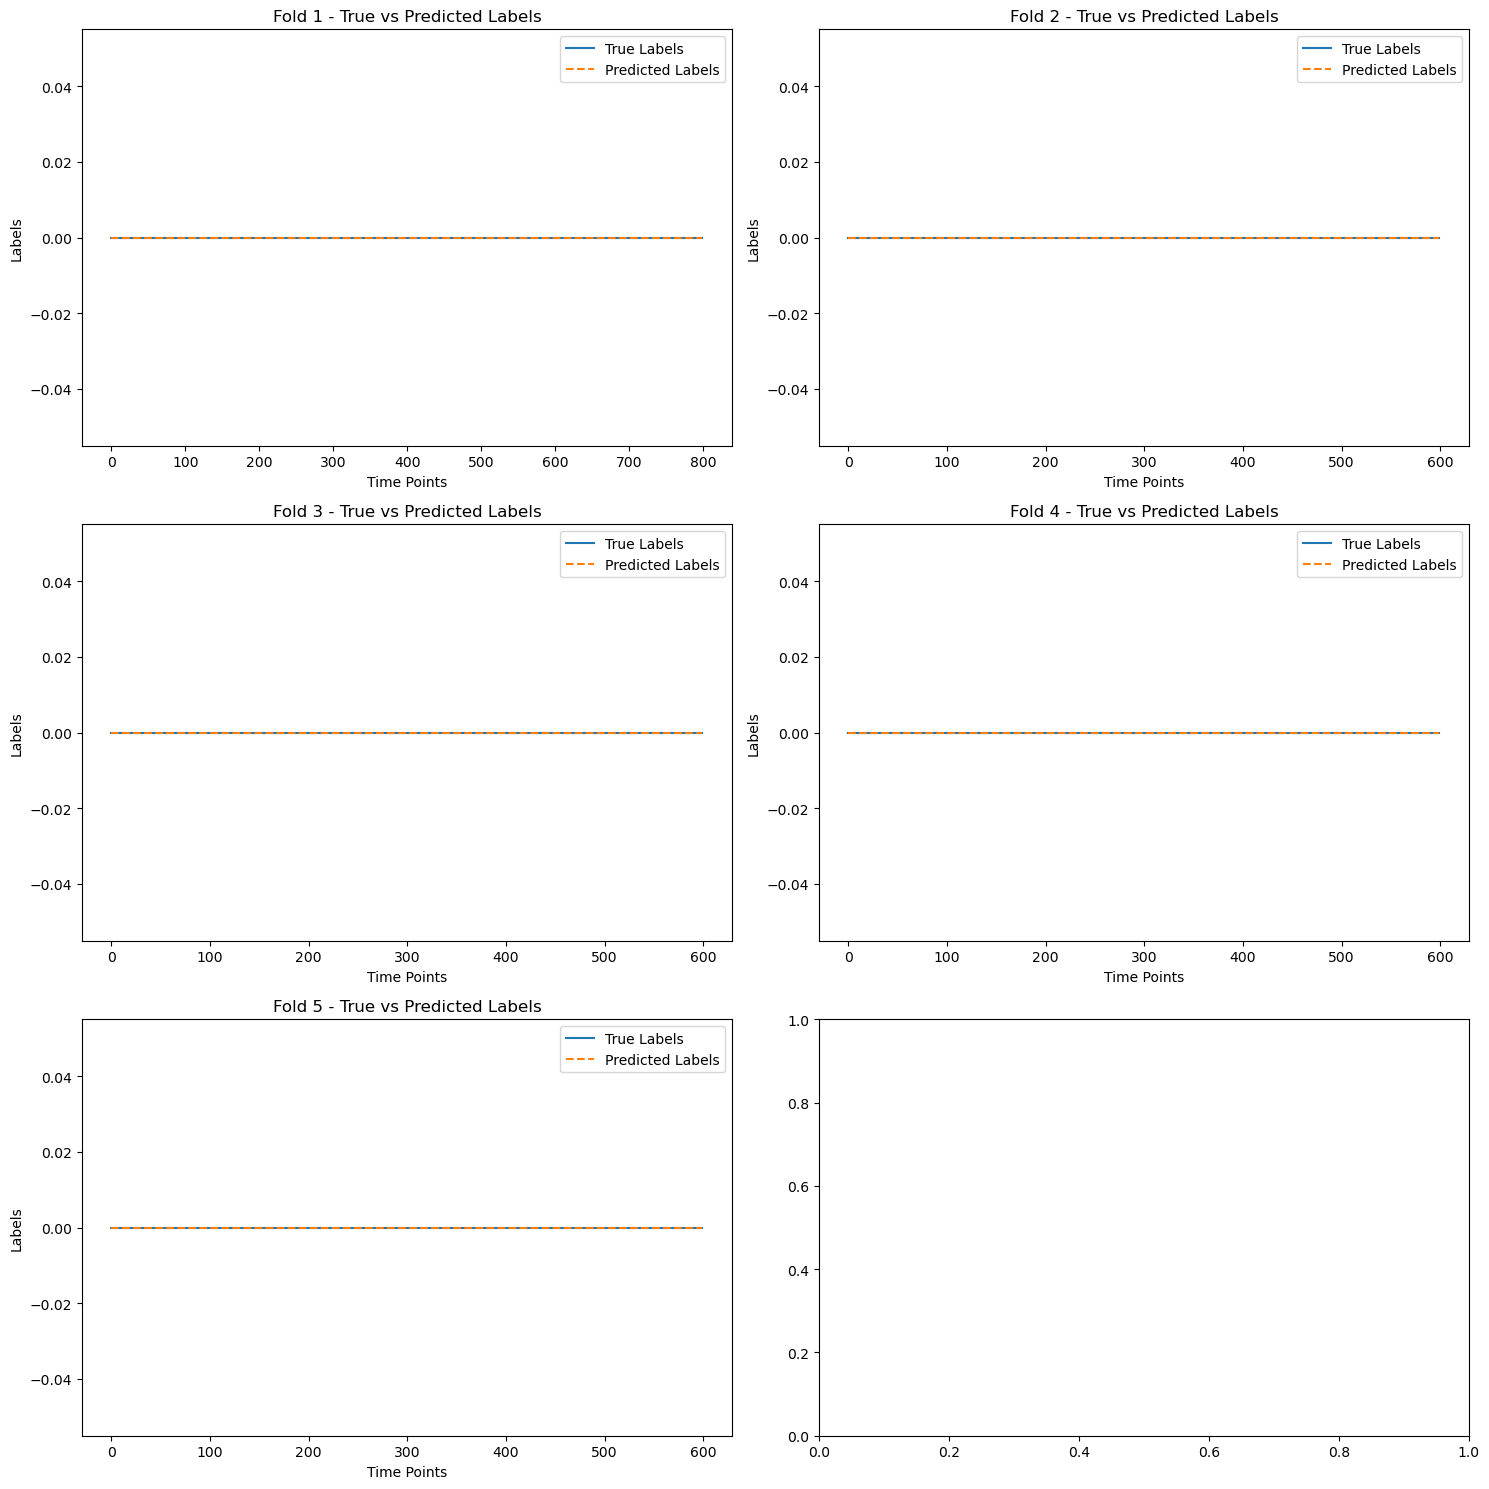

In [ ]:
import matplotlib.pyplot as plt

# Number of folds
num_folds = len(continuousTime_results.keys())

# Determine the grid size for subplots
cols = 2
rows = (num_folds + 1) // cols

# Create a figure with subplots
fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))

# Plot y_test against y_pred for each fold
for i, fold in enumerate(continuousTime_results.keys()):
    y_test = continuousTime_results[fold]['y_test']
    y_pred = continuousTime_results[fold]['y_pred']
    
    ax = axes[i // cols, i % cols]
    ax.plot(y_test.flatten(), label='True Labels')
    ax.plot(y_pred.flatten(), label='Predicted Labels', linestyle='--')
    ax.set_xlabel('Time Points')
    ax.set_ylabel('Labels')
    ax.set_title(f'Fold {fold} - True vs Predicted Labels')
    ax.legend()

# Adjust layout
plt.tight_layout()
plt.show()